In [4]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import re
import ast
import time

# OpenAI 관련
import tiktoken
import openai
from dotenv import load_dotenv

# 타임아웃 처리
from timeout_decorator import timeout

# Jupyter 설정
%matplotlib inline

# scikit-learn
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# scikit-survival
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import (
    RandomSurvivalForest,
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis
)
from sksurv.util import Surv

set_config(display="text")

In [ ]:
# 데이터 불러오기
finance_df=pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/재무제표정보_train.csv")
company_info_df=pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/기업정보요약_train.csv")
result_rnd=pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/국가R&D성과_train.csv")
report_rnd=pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/국가R&D연구보고서_train.csv")
design_df = pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/디자인권정보_train.csv")
mark_df = pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/상표권정보_train.csv")
patent_df = pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/특허정보상세_train.csv")
rnd_list = pd.read_csv("../Data/DBI2023-Track1-학습데이터셋_v3/국가R&D과제_train.csv", low_memory=False)

## 재무제표 전처리

In [ ]:
finance_df=finance_df.drop(columns=['Unnamed: 0','stNm','acctCd']) #사용하지 않을 열 제거
#print(finance_df.head())

unique_num = finance_df['BusinessNum'].unique()  #같은 회사를 한 행으로 표현하기 위한 전처리 시작

In [ ]:
#accNm 열의 값들을 열로 바꾸고 그 값으로 acctAmt을 넣는 작업
result_data = []

# 각 BusinessNum에 대한 작업 수행
for num in unique_num:
    # 해당 BusinessNum에 대한 데이터만 필터링
    num_data = finance_df[finance_df['BusinessNum'] == num]

    # stYear 열에서 최댓값 찾기 > 한 회사의 여러 년도 데이터가 있는 경우 최신 데이터만 남기기 위함
    max_year = num_data['stYear'].max()

    # 데이터를 딕셔너리로 만들어 결과 리스트에 추가
    result_data.append({'BusinessNum': num, 'stYear': max_year, **num_data.set_index('accNm')['acctAmt'].to_dict()})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(result_data)

,BusinessNum,stYear,NaN,유동자산,당좌자산,매출채권,재고자산,투자자산,자산총계,유동부채,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1051505526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2118605035,2020.0,NaN,8164660.0,8164660.0,1507124.0,24015.0,7804550.0,23396937.0,2912121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2298104710,2021.0,NaN,16464882.0,12260201.0,7140471.0,4204681.0,1009720.0,23581526.0,6193372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4818104219,2021.0,NaN,1016977.0,1016977.0,763150.0,0.0,45000.0,2271279.0,349911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1178100918,2021.0,NaN,7563760.0,7563760.0,303432.0,NaN,7570025.0,16800127.0,5642826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1248600665,2021.0,NaN,1392212.0,1311346.0,335087.0,80866.0,21395.0,1606617.0,219663.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7996,2068607541,2020.0,NaN,784480.0,630554.0,210147.0,153926.0,NaN,924813.0,150789.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7997,8778607222,2021.0,NaN,51201.0,51201.0,44566.0,0.0,0.0,1043561.0,253737.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7998,1448101319,2020.0,NaN,1663314.0,1659871.0,1213277.0,3442.0,NaN,1727626.0,626217.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
exclude_column = ['BusinessNum','stYear']  # drop에서 제외할 열
#특정 column을 제외하고 나머지 열의 값이 모두 NaN인 경우 행 제거
df_cleaned = result_df.loc[result_df.drop(exclude_column, axis=1).dropna(how='all').index]

,BusinessNum,stYear,NaN,유동자산,당좌자산,매출채권,재고자산,투자자산,자산총계,유동부채,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2118605035,2020.0,NaN,8164660.0,8164660.0,1507124.0,24015.0,7804550.0,23396937.0,2912121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2298104710,2021.0,NaN,16464882.0,12260201.0,7140471.0,4204681.0,1009720.0,23581526.0,6193372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4818104219,2021.0,NaN,1016977.0,1016977.0,763150.0,0.0,45000.0,2271279.0,349911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1178100918,2021.0,NaN,7563760.0,7563760.0,303432.0,NaN,7570025.0,16800127.0,5642826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2118603748,2021.0,NaN,1951334.0,1221805.0,29131.0,729529.0,66663.0,2409438.0,419292.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1248600665,2021.0,NaN,1392212.0,1311346.0,335087.0,80866.0,21395.0,1606617.0,219663.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7996,2068607541,2020.0,NaN,784480.0,630554.0,210147.0,153926.0,NaN,924813.0,150789.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7997,8778607222,2021.0,NaN,51201.0,51201.0,44566.0,0.0,0.0,1043561.0,253737.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7998,1448101319,2020.0,NaN,1663314.0,1659871.0,1213277.0,3442.0,NaN,1727626.0,626217.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
finance_df = df_cleaned.dropna(axis=1, how='all') #열의 모든 값이 NaN인 경우 열 제거

,BusinessNum,stYear,유동자산,당좌자산,매출채권,재고자산,투자자산,자산총계,유동부채,비유동부채,...,제조경비,제조원가,원재료,자본잉여금,수출액1,수출액2,수출액3,수출액5,당좌부채(당좌차월),수출액4
1,2118605035,2020.0,8164660.0,8164660.0,1507124.0,24015.0,7804550.0,23396937.0,2912121.0,14490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2298104710,2021.0,16464882.0,12260201.0,7140471.0,4204681.0,1009720.0,23581526.0,6193372.0,2831485.0,...,18070188.0,65276312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4818104219,2021.0,1016977.0,1016977.0,763150.0,0.0,45000.0,2271279.0,349911.0,922670.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1178100918,2021.0,7563760.0,7563760.0,303432.0,NaN,7570025.0,16800127.0,5642826.0,1366631.0,...,6506108.0,7517848.0,NaN,197370.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2118603748,2021.0,1951334.0,1221805.0,29131.0,729529.0,66663.0,2409438.0,419292.0,10000.0,...,536674.0,3550962.0,373166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1248600665,2021.0,1392212.0,1311346.0,335087.0,80866.0,21395.0,1606617.0,219663.0,176000.0,...,122187.0,961680.0,80866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7996,2068607541,2020.0,784480.0,630554.0,210147.0,153926.0,NaN,924813.0,150789.0,132514.0,...,772299.0,1592782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7997,8778607222,2021.0,51201.0,51201.0,44566.0,0.0,0.0,1043561.0,253737.0,811546.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7998,1448101319,2020.0,1663314.0,1659871.0,1213277.0,3442.0,NaN,1727626.0,626217.0,200000.0,...,1723647.0,2535517.0,3442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Altman_Z score 계산

In [18]:
finance_df=finance_df.fillna(0) # 계산을 위해 NaN 값을 0으로 채우기

In [19]:
#재무제표 데이터를 활용하여 revised Altman Z-Score 계산 시작
Altman_df=pd.DataFrame()

Altman_df['BusinessNum'] = finance_df['BusinessNum']
# (운전 자본 / 총 자산)
Altman_df['운전자본/총자산'] = (finance_df['유동자산'] - finance_df['유동부채']) / finance_df['자산총계']

# (이익잉여금 / 총 자산)
Altman_df['이익잉여금/총자산'] = finance_df['이익잉여금'] / finance_df['자산총계']

# (이자 및 세금 전 이익 / 총 자산)
Altman_df['EBIT/총자산'] = (finance_df['당기순이익(손실)']+ finance_df['법인세비용']+finance_df['이자비용'] )/ finance_df['자산총계']

# (자기자본의 장부가치 / 총 부채)
Altman_df['자기자본/총부채'] = finance_df['자기자본'] / finance_df['부채총계']

# (매출액 / 총 자산)
Altman_df['매출액/총자산'] = finance_df['매출액'] / finance_df['자산총계']

In [21]:
exclude_column=['BusinessNum']
Altman_df = Altman_df.loc[Altman_df.drop(exclude_column, axis=1).dropna(how='all').index]

In [ ]:
# revised Altman Z-score 계산
Altman_zscore=pd.DataFrame()
Altman_zscore['BusinessNum']=Altman_df['BusinessNum']
Altman_zscore['Z_score']=0.717*Altman_df['운전자본/총자산']+0.847*Altman_df['이익잉여금/총자산'] +3.107*Altman_df['EBIT/총자산']+0.420*Altman_df['자기자본/총부채']+ 0.998*Altman_df['매출액/총자산']

,BusinessNum,Z_score
1,2118605035,6.499504
2,2298104710,4.605482
3,4818104219,2.878020
4,1178100918,2.438344
7,2118603748,4.903939
...,...,...
7995,1248600665,3.278908
7996,2068607541,4.495237
7997,8778607222,-0.371725
7998,1448101319,3.512808


In [ ]:
def label_status(value):
    if value >= 2.9:
        return '건강'
    elif value >= 1.23:
        return '불안정'
    else:
        return '위험'

# 새로운 열 '상태' 추가
Altman_zscore['재무안정성'] = Altman_zscore['Z_score'].apply(label_status)
Altman_zscore

,BusinessNum,Z_score,재무안정성
1,2118605035,6.499504,건강
2,2298104710,4.605482,건강
3,4818104219,2.878020,불안정
4,1178100918,2.438344,불안정
7,2118603748,4.903939,건강
...,...,...,...
7995,1248600665,3.278908,건강
7996,2068607541,4.495237,건강
7997,8778607222,-0.371725,위험
7998,1448101319,3.512808,건강


## 기업 정보 요약 전처리

In [25]:
company_info_df=company_info_df[['BusinessNum','cmpSclNm','indNm']]

In [28]:
#한국표준산업분류표의 키워드를 활용하여 추출할 키워드 정의
industry_keywords = ['농업','임업','어업','광업','천연가스','원유','채굴업','제조업',
                     '제작업','컴퓨터','통신','전기','공급업','운송업','운반업','재생업','건설',
                     '처리업','도매','소매','중개업','판매업','운수','창고','숙박','운영','음식','식당','관리','방송','출판',
                     '영상','서비스업','정보','금융','보험','부동산','임대','연구','개발','법무','회계','세무','광고','여론','디자인',
                     '촬영','교육','행정','보건','복지','스포츠','오락','수리','가구','공사업','청소업','발전','인쇄','협회','생산','단체','택배업','미용','의원']

In [29]:
#indNm열의 값을 정의한 키워드로 분류
company_info_df['industry']=None
for i, industry in enumerate(company_info_df['indNm']):
    industry_list = []
    for keyword in industry_keywords:
        if keyword in str(industry):
            industry_list.append(keyword)
    company_info_df.at[i, 'industry'] = industry_list

<ipython-input-29-572b1adce386>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info_df['industry']=None


In [31]:
# 분류되지 않은 업종 기타로 변경
for i in range(len(company_info_df['industry'])):
    if len(company_info_df['industry'][i]) == 0:
        company_info_df.at[i, 'industry'] = ['기타']

In [ ]:
#재무제표의 Altman Z-Score와 기업 정보 요약 데이터 합치기
company_total_df = pd.merge(Altman_zscore, company_info_df, on='BusinessNum', how='left')
company_total_df=company_total_df.drop(columns=['indNm']) # 기존 업종 분류 열 drop
company_total_df=company_total_df[company_total_df.notna().any(axis=1)][company_total_df['cmpSclNm']=='중소기업'] #기업 규모 분류가 중소기업인 행 저장

## GPT API 키워드 추출 및 RnD 파일전처리

In [ ]:
dotenv_path = ".env"
load_dotenv(dotenv_path)
apikey = os.getenv("API_KEY")

rnd_list = rnd_list.fillna('z')

final_df = pd.DataFrame(columns=['BusinessNum', 'total'])

for c in list(set(rnd_list['BusinessNum'])):
    df = rnd_list[rnd_list['BusinessNum'] == c].reset_index(drop=True)

    df['p_name'] = df['ProjectNameKR']

    df['p_info'] =  df['GoalFull'] + df['AbstractFull'] + df['EffectFull']
    df = df.drop(['ProjectNameKR', 'GoalFull', 'AbstractFull', 'EffectFull'], axis=1)

    df['total_class'] = df['Scienceclass_New_1_Large'] + '>' +  df['Scienceclass_New_1_Midium'] + '>' +  df['Scienceclass_New_1_Small']
    df = df.drop(['Scienceclass_New_1_Large', 'Scienceclass_New_1_Midium', 'Scienceclass_New_1_Small'], axis=1)

    df['total'] = df['KeywordKR'] + '`' + df['p_name'] + '`' + df['p_info']
    df = df.drop(['ProjectStart', 'ProjectEnd', 'KeywordKR', 'p_name', 'p_info', 'total_class', 'Region', 'DevelopmentPhases', 'TechLifecycle'], axis=1)

    array = df.loc[0]
    array['total'] = list(df['total'])

    final_df.loc[len(final_df)] = array

In [39]:
# RnD 수행개수 count

rnd_count = final_df.copy()

rnd_count['total'] = rnd_count['total'].apply(len)

rnd_count.to_excel("rnd_count.xlsx", engine='openpyxl', index=True)

def remove_entries_with_z(lst):
    return [entry for entry in lst if 'z' not in entry]

final_df['total'] = final_df['total'].apply(remove_entries_with_z)
print(final_df)

final_df = final_df[final_df['total'].str.len() > 0]

     BusinessNum                                              total
0     1178107908  [라디오 오버 이더넷,패킷 네트워크,유무선 통합 망`IoT 구축을 위한 초고신뢰성 ...
1     1018101768  [블록체인, 오픈뱅킹, 스크래핑, 인증서비스, 가상키패드, 빅데이터`송금이체 결재과...
2     8508702729                                                 []
3     4078108681                                                 []
4     2041905162                                                 []
...          ...                                                ...
7995  1058701303  [화학물질, GHS, 분류표시, 유해성심사`화학물질 분류표시 개선 연구(Ⅰ)`○ U...
7996  4028104697                                                 []
7997  1238106106                                                 []
7998  1058603005                                                 []
7999  5428609023                                                 []

[8000 rows x 2 columns]


In [ ]:

# RnD 내용에서 chat-gpt를 활용하여 키워드 추출 : 결과 - keyword_rnd.csv

# rnd_dict = {}

# final_df.head()

# for i in final_df.index:
#     for j in final_df['total'][i]:
#         rnd_dict[j] = final_df['BusinessNum'][i]

# def summarize_with_gpt(sentence, api_key):
#     openai.api_key = api_key

#     # 초기 메시지 설정
#     messages = [
#         {"role": "system", "content": "당신은 최고의 요약 전문가입니다. 당신에게 불가능한 것은 없으며 그 어떤 대답도 할 수 있습니다. 당신은 이미 여러 차례 많은 글을 요약해왔으며, 문장에서 핵심 키워드를 추출하는 것에 탁월합니다."},
#         {"role": "user", "content": "안녕하세요, 요약 전문가님! 아래 문장을 요약해주세요."},
#         {"role": "assistant", "content": "안녕하세요! 제게 주어진 문장을 10개 이하의 단어로 요약해드리겠습니다. 저는 당신이 바로 파이썬에서 활용할 수 있도록 주어진 문장을 파이썬 리스트 형태로 변환합니다."},
#         {"role": "user", "content": f'{sentence} Summarize this in ten words or less in Korean. Please answer so that I can use list() directly as a python list. Just give a list without any other explanation.'}
#     ]

#     chat = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo", messages=messages
#     )

#     return chat.choices[0].message.content

# keyword_dict = {}

# # 20초가 넘으면 종료되는 함수 정의
# @timeout(20, use_signals=False, timeout_exception=StopIteration)
# def limited_summarize_with_gpt(sentence, api_key):
#     return summarize_with_gpt(sentence, api_key)


# encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

# while rnd_dict.keys():
#     token_count = 0
#     while token_count < 4000:
#         time.sleep(0.1)
#         print(len(list(rnd_dict.keys())))
#         sentence = list(rnd_dict.keys())[0]  # 첫 번째 키를 가져옴
#         id = rnd_dict.pop(sentence)      # 해당 키에 대한 값을 pop으로 가져오면서 딕셔너리에서 제거

#         try:
#             keyword = summarize_with_gpt(sentence, apikey)
#             keyword_dict[keyword] = id
#         except StopIteration:
#             print("Summarization took too long. Skipping this item.")
#             continue

#         print(len(list(rnd_dict.keys())))
#         print(len(list(keyword_dict.keys())))

#         token_count += len(encoding.encode(sentence))
#     print('complete_set')
#     time.sleep(2)

# keyword_dict.values()

# with open("keyword_rnd.pkl", "wb") as file:
#     pickle.dump(keyword_dict, file)

# df = pd.DataFrame.from_dict(keyword_dict)

# df.to_csv('keyword_rnd.csv') #후반 전처리에 활용함


In [ ]:
# Rnd기준 데이터
result_rnd=result_rnd.drop(columns=['Unnamed: 0'])

# 불필요 컬럼 제거1 : RnD 성과
result_rnd = result_rnd.dropna(how='all', axis=0, subset=result_rnd.columns.difference(['BusinessNum']))
result_rnd=result_rnd.drop(columns=['SitId','ProjectCode','EquipId','ProjectYear','MinistryCode','BudgetProjectNo','PerformAgentCode','6TCode','TechnologyRoadMapCode','ScienceClassCode1','ScienceClassCode2','ScienceClassCode3'])

result_rnd['Year'] = result_rnd.groupby(['BusinessNum', 'ProjectName'])['Year'].transform('max')
result_rnd.drop_duplicates(['BusinessNum', 'ProjectName'], keep='first', inplace=True)

result_rnd=result_rnd.drop(columns=['EquipNo'])

report_rnd=report_rnd.drop(columns=['ManagerName','ProjectNumber','PublicationCountry','Unnamed: 0'])
report_rnd = report_rnd.dropna(how='all', axis=0, subset=report_rnd.columns.difference(['BusinessNum']))
report_rnd= report_rnd.drop_duplicates(subset=['ResearchPublicNo'], keep='first')
report_rnd.drop_duplicates(['BusinessNum', 'ResultTitleKR'], keep='first', inplace=True)

# 불필요 컬럼 제거 : RnD 연구보고서
report_rnd=report_rnd.drop(columns=['ResearchPublicNo'])
report_rnd=report_rnd.drop(columns=['ResultTitleKR'])
report_rnd=report_rnd[['BusinessNum','ProjectTitle','Contents','PublicationAgency']]
report_rnd=report_rnd.drop(columns=['Contents','PublicationAgency'])

# 불필요 컬럼 제거2 : RnD 성과
result_rnd.rename(columns={'ProjectName': 'ProjectTitle'}, inplace=True)
result_rnd=result_rnd.drop(columns=['Year','MinistryName','BudgetName','PerformAgent','6TName','TechnologyRoadMapName','ScienceClassName1','ScienceClassName2','ScienceClassName3'])

# 데이터 병합 : RnD 연구보고서, RnD 성과
total_result=pd.concat([report_rnd, result_rnd])
total_result=total_result.drop_duplicates(subset=['BusinessNum', 'ProjectTitle'])


,BusinessNum,ProjectTitle
0,1051505526,조명 제어용 파워릴레이의 접촉 내구성(수명) 향상기술개발
1,1051505526,굴삭기용 드라이브 샤프트(요크 샤프트)에 대한 단조기술 개발
2,1051505526,차단기 부품 코킹 자동화 system 구축
3,1051505526,모터 컨트롤 unit module화 공정기술 개발
4,1051505526,제진기능 향상을 위한 Multi level Automatic 제진기
...,...,...
27449,1212000004,u-City 환경 기반 하이브리드 u-로봇 서비스 시스템 기술 개발
27450,1212000004,양자암호통신망 구축을 통한 신뢰성 검증기술 및 QKD 고도화를 위한 핵심요소기술 개발
27453,1212000004,통신장비에 적용을 위한 양자이론 기반의 퀀텀 리피터 기술 연구
27463,1212000004,(주관)음성 및 정신질환 예측/진단/관리를 위한 음성-언어-생체신호 통합 인공지능 ...


In [42]:
# RnD 결과데이터 : RnD 보고서 및 결과의 엑셀파일에 있는 RnD 과제에 대해 1값 부여(없을경우 0)
rnd_list_nodup = rnd_list.drop_duplicates(subset='ProjectNameKR')

RnD_result = total_result

rnd_list_nodup['result'] = [0]*len(rnd_list_nodup.index)

for i in rnd_list_nodup['ProjectNameKR'].index:
    for j in RnD_result['ProjectTitle']:
        if j == rnd_list_nodup['ProjectNameKR'][i]:
            rnd_list_nodup.loc[i, 'result'] = 1
            print(i)

# rnd_list_nodup['result'].value_counts()

# 날짜 데이터 : RnD과제에 대해 시작 날짜와 끝 날짜 정리, '일' 단위 계산 및 대체
rnd_list_new = rnd_list[['BusinessNum', 'ProjectNameKR', 'ProjectStart', 'ProjectEnd']]

rnd_date = rnd_list[['ProjectNameKR', 'ProjectStart', 'ProjectEnd']]
rnd_date_notna = rnd_date[rnd_date['ProjectNameKR'] != 'z']
r_list = list(set(rnd_date_notna['ProjectNameKR']))

date_dict = {}
for rnd in r_list:
    rnd_data = rnd_date_notna[rnd_date_notna['ProjectNameKR'] == rnd]
    startdate = min(rnd_data['ProjectStart'])
    enddate = max(rnd_data['ProjectEnd'])
    date_list = [startdate, enddate]
    date_dict[rnd] = date_list


rnd_list_nodup['StartDate'] = rnd_list_nodup['ProjectNameKR'].map(lambda x: date_dict.get(x, [None, None])[0])
rnd_list_nodup['EndDate'] = rnd_list_nodup['ProjectNameKR'].map(lambda x: date_dict.get(x, [None, None])[1])


rnd_final = rnd_list_nodup[['BusinessNum', 'ProjectNameKR', 'result', 'StartDate', 'EndDate']]
rnd_final.replace('z', np.nan, inplace=True)
rnd_final['Duration'] = (pd.to_datetime(rnd_final['EndDate']) - pd.to_datetime(rnd_final['StartDate'])).dt.days

# 엑셀 파일로 저장
rnd_final.to_excel("rnd_data_final.xlsx", index=True)


<ipython-input-42-f80b0b2efd7b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnd_list_nodup['result'] = [0]*len(rnd_list_nodup.index)


3
8
17
22
29
120
151
152
153
155
192
199
199
472
670
711
712
856
858
860
865
1051
1057
1061
1065
1099
1492
1532
1532
1538
1588
1654
1679
1778
1788
1803
1805
1903
2031
2112
2148
2210
2212
2302
2439
2439
2474
2479
2503
2554
2625
2631
2774
2899
2900
2962
2964
3367
3368
3369
3375
3435
3610
3612
3612
3613
3619
3624
3624
3628
3629
3751
3751
3755
3755
3759
3778
3786
3786
3790
3798
3799
3802
3802
3803
3805
3806
3811
3823
3843
3863
3876
3879
3880
3896
3929
3929
3931
3936
3990
4009
4035
4045
4091
4100
4100
4112
4183
4189
4201
4233
4293
4294
4310
4310
4310
4402
4430
4528
4540
4670
4676
4770
4770
4771
4772
4775
4804
4805
4965
5055
5125
5180
5180
5193
5194
5433
5444
5606
5754
5755
5775
5900
5903
5906
5916
5917
6138
6149
6154
6246
6256
6257
6648
6649
6649
6649
6649
6649
6649
6649
6649
6649
6654
6664
6676
6746
6830
6889
6934
6952
6957
7194
7201
7234
7235
7373
7506
7581
7684
7698
7699
7701
7702
7703
7782
8069
8072
8075
8086
8212
8237
8237
8237
8237
8237
8237
8297
8353
8353
8353
8353
8353
8353
8353
857

<ipython-input-42-f80b0b2efd7b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnd_list_nodup['StartDate'] = rnd_list_nodup['ProjectNameKR'].map(lambda x: date_dict.get(x, [None, None])[0])
<ipython-input-42-f80b0b2efd7b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnd_list_nodup['EndDate'] = rnd_list_nodup['ProjectNameKR'].map(lambda x: date_dict.get(x, [None, None])[1])
<ipython-input-42-f80b0b2efd7b>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



In [43]:
# 회사별 특허, 디자인권, 상표권 통합 데이터 생성

design_df = design_df.dropna(subset=design_df.columns.difference(['Unnamed: 0','BusinessNum']), how='all')
mark_df = mark_df.dropna(subset=mark_df.columns.difference(['Unnamed: 0','BusinessNum']), how='all')
patent_df = patent_df.dropna(subset=patent_df.columns.difference(['Unnamed: 0','BusinessNum']), how='all')


design_df = design_df[['BusinessNum', 'applicationStatus', 'articleName']]

# design_status_set = list(set(design_df['applicationStatus'])) # 아이디어 상태 확인

design_df['total_info'] = design_df[design_df.columns[1]] + '/' + design_df[design_df.columns[2]]
design_df = design_df.drop(design_df.columns[1:3], axis=1)

mark_df = mark_df[['BusinessNum', 'title']]

patent_df = patent_df[['BusinessNum', 'patentTitle', 'pubReg', 'abstract']]

patent_status_set = list(set(patent_df['pubReg'])) # 아이디어 상태 확인

patent_df['total_info'] = patent_df['patentTitle'] + ' : ' + patent_df['abstract']
patent_df = patent_df[['BusinessNum', 'total_info']]

total_company = sorted(list(set(design_df['BusinessNum']) | set(mark_df['BusinessNum']) | set(patent_df['BusinessNum'])))

df_company_tec = pd.DataFrame(columns = ['design', 'mark', 'patent'], index = total_company)

for c in total_company:
    design_list = list(design_df[design_df['BusinessNum'] ==c]['total_info'])
    mark_list = list(mark_df[mark_df['BusinessNum'] ==c]['title'])
    patent_list = list(patent_df[patent_df['BusinessNum'] ==c]['total_info'])

    if design_list != []:
        df_company_tec.loc[c, 'design'] = design_list
    else : df_company_tec.loc[c, 'design'] = np.nan

    if mark_list != []:
        df_company_tec.loc[c, 'mark'] = mark_list
    else : df_company_tec.loc[c, 'mark'] = np.nan

    if patent_list != []:
        df_company_tec.loc[c, 'patent'] = patent_list
    else : df_company_tec.loc[c, 'patent'] = np.nan


def replace_nan_with_empty_list(x):
    if isinstance(x, list):
        return [item for item in x if item == item]  # NaN은 자기 자신과 동일하지 않다는 속성을 이용
    elif x != x:  # NaN 값에 대한 확인
        return []
    else:
        return x

df_company_tec = df_company_tec.applymap(replace_nan_with_empty_list)
df_company_tec = df_company_tec.applymap(lambda x: list(set(x)) if isinstance(x, list) else x)

df_company_tec.head(2)

# 특허, 디자인권, 상표권 개수 데이터 생성

company_count_df = pd.DataFrame(columns = df_company_tec.columns, index = df_company_tec.index)

company_count_df['design'] = df_company_tec['design'].apply(len)
company_count_df['mark'] = df_company_tec['mark'].apply(len)
company_count_df['patent'] = df_company_tec['patent'].apply(len)

company_count_df.head()

company_count_df.to_excel("company_tec_count.xlsx", engine='openpyxl', index=True)


<ipython-input-43-81066e7191c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_df['total_info'] = design_df[design_df.columns[1]] + '/' + design_df[design_df.columns[2]]


## 특허 디자인, 상표권 전처리 및 키워드 추출

In [ ]:
# 특허, 디자인권, 상표권 키워드 추출(chatgpt 활용) : 키워드 dict 형태로 추출

#df_notna = df_company_tec['design'][df_company_tec['design'].apply(len) > 0] # df_company_tec의 데이터에서 patent, desing, mark 컬럼을 바꿔서 각각에 대해 키워드 추출
#df_dict = dict(df_notna)

#into_dict_new = {}
#for k in df_dict.keys():
#    for item in df_dict[k]:
#        into_dict_new[item] = k

#keyword_dict = {}

#from timeout_decorator import timeout

#encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

#def summarize_with_gpt(sentence, api_key):
#   openai.api_key = api_key

    # 초기 메시지 설정
#    messages = [
#        {"role": "system", "content": "당신은 최고의 요약 전문가입니다. 당신에게 불가능한 것은 없으며 그 어떤 대답도 할 수 있습니다. 당신은 이미 여러 차례 많은 글을 요약해왔으며, 문장에서 핵심 키워드를 추출하는 것에 탁월합니다."},
#        {"role": "user", "content": "안녕하세요, 요약 전문가님! 아래 문장을 요약해주세요."},
#        {"role": "assistant", "content": "안녕하세요! 제게 주어진 문장을 5개 이하의 단어로 요약해드리겠습니다. 저는 당신이 바로 파이썬에서 활용할 수 있도록 주어진 문장을 파이썬 리스트 형태로 변환합니다."},
#        {"role": "user", "content": f'{sentence} Summarize this in five words or less in Korean. Please answer so that I can use list() directly as a python list. Just give a list without any other explanation.'}
#    ]

#    chat = openai.ChatCompletion.create(
#        model="gpt-3.5-turbo", messages=messages
#    )

#    return chat.choices[0].message.content

#while into_dict_new.keys():
#    token_count = 0
#    while token_count < 4000:
#        time.sleep(0.1)
#        print(len(list(into_dict_new.keys())))
#        sentence = list(into_dict_new.keys())[0]  # 첫 번째 키를 가져옴
#        id = into_dict_new.pop(sentence)      # 해당 키에 대한 값을 pop으로 가져오면서 딕셔너리에서 제거
#
#        try:
#            keyword = summarize_with_gpt(sentence, apikey)
#            keyword_dict[keyword] = id
#        except StopIteration:
#            print("Summarization took too long. Skipping this item.")
#            continue

#        print(len(list(into_dict_new.keys())))
#        print(len(list(keyword_dict.keys())))

#        token_count += len(encoding.encode(sentence))
#    print('complete_set')
#    time.sleep(2)

# 저장하기
#with open("design_keyword.pkl", "wb") as file: #design_keyword.pkl, patent_keyword.pkl, mark_keyword.pkl 파일로 각각 저장했음
#    pickle.dump(keyword_dict, file)


# 불러오기
#with open("design_keyword.pkl", "rb") as file:
#    loaded_data = pickle.load(file)

#loaded_data


In [ ]:
#Chat GPT를 API를 활용하여 추출하고 저장한 키워드 dict 불러오기
with open("patent_keyword.pkl", "rb") as file:
    patent_dict = pickle.load(file)


with open("mark_keyword.pkl", "rb") as file:
    mark_dict = pickle.load(file)

with open("design_keyword.pkl", "rb") as file:
    design_dict = pickle.load(file)

# 정규식을 사용하여 단어를 추출
def extract_words(text):
    words = re.findall(r'\b\w+\b', text)
    return words

# 주어진 딕셔너리를 처리하여 같은 value를 가진 key들을 하나로 묶음
def group_keys_by_value(input_dict):
    new_dict = {}
    grouped_dict = {}

    for key, value in input_dict.items():
        words = extract_words(key)
        for word in words:
            new_dict[word] = value

    for key, value in new_dict.items():
        if value in grouped_dict:
            grouped_dict[value].append(key)
        else:
            grouped_dict[value] = [key]

    return grouped_dict


design_dict = group_keys_by_value(design_dict)
patent_dict = group_keys_by_value(patent_dict)
mark_dict = group_keys_by_value(mark_dict)

total_company_list = list(set(design_dict.keys()).union(set(patent_dict.keys()), set(mark_dict.keys())))

total_company_dict = {}
for c in total_company_list:
    tec_dict = {}
    if c in list(design_dict.keys()):
        design = design_dict[c]
    else : design = []

    if c in list(patent_dict.keys()):
        patent = patent_dict[c]
    else : patent = []

    if c in list(mark_dict.keys()):
        mark = mark_dict[c]
    else : mark = []

    tec_dict['design'] = design
    tec_dict['patent'] = patent
    tec_dict['mark'] = mark

    total_company_dict[c] = tec_dict


company_tec_keyword = pd.DataFrame(total_company_dict).transpose()


company_tec_keyword.head()

def convert_list_to_string(list):
    return ', '.join(["'{}'".format(item) for item in list])

# 데이터프레임의 각 셀 값을 문자열로 변환
company_tec_keyword = company_tec_keyword.applymap(convert_list_to_string)

# 엑셀 파일로 저장
company_tec_keyword.to_excel("company_tec_keyword.xlsx", index=True)


### 키워드 점수화

In [61]:
# 키워드 추출한 파일, R&D 결과, 기간 데이터 파일 불러오기
tec_keyword=pd.read_excel('company_tec_keyword.xlsx')
rnd_keyword=pd.read_csv('keyword_rnd.csv')

In [ ]:
rnd_keyword.rename(columns={'0':'BusinessNum','Unnamed: 0':'rnd_keyword'},inplace=True)
tec_keyword.rename(columns={'Unnamed: 0':'BusinessNum'},inplace=True)

In [68]:
# 문자열 리스트로 변환
for i in range(len(tec_keyword['design'])):
    value = tec_keyword['design'][i]
    if isinstance(value, str):
        keywords_list = [word.strip("'") for word in value.split(', ')]
        tec_keyword['design'][i] = keywords_list


<ipython-input-68-cc8b32b8d658>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tec_keyword['design'][i] = keywords_list


In [69]:
for i in range(len(tec_keyword['mark'])):
    value = tec_keyword['mark'][i]
    if isinstance(value, str):
        keywords_list = [word.strip("'") for word in value.split(', ')]
        tec_keyword['mark'][i] = keywords_list

<ipython-input-69-e33c4740e357>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tec_keyword['mark'][i] = keywords_list


In [70]:
for i in range(len(tec_keyword['patent'])):
    value = tec_keyword['patent'][i]
    if isinstance(value, str):
        keywords_list = [word.strip("'") for word in value.split(', ')]
        tec_keyword['patent'][i] = keywords_list

<ipython-input-70-c235b1c58176>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tec_keyword['patent'][i] = keywords_list


In [72]:
merged_df = pd.merge(rnd_final, tec_keyword, on='BusinessNum', how='left') # rnd 성공 건수, 기간 데이터와 키워드 데이터 병합

In [74]:
scores = []

# 각 R&D 프로젝트 이름에 대해 특정 회사의 각 키워드를 검색하고 점수를 부여
for project_name, company_keywords_list in zip(merged_df['ProjectNameKR'], merged_df['design']):
    if isinstance(project_name, str) and isinstance(company_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for keyword in company_keywords_list:
            if keyword in project_name:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 문자열이 아니거나 키워드 리스트가 아닌 경우 0으로 처리

merged_df['design_score'] = scores #새로운 열을 만들어 값 추가


In [75]:
scores = []

# 각 R&D 프로젝트 이름에 대해 특정 회사의 각 키워드를 검색하고 점수를 부여
for project_name, company_keywords_list in zip(merged_df['ProjectNameKR'], merged_df['patent']):
    if isinstance(project_name, str) and isinstance(company_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for keyword in company_keywords_list:
            if keyword in project_name:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 문자열이 아니거나 키워드 리스트가 아닌 경우 0으로 처리

merged_df['patent_score'] = scores


In [76]:
scores = []

# 각 R&D 프로젝트 이름에 대해 특정 회사의 각 키워드를 검색하고 점수를 부여
for project_name, company_keywords_list in zip(merged_df['ProjectNameKR'], merged_df['mark']):
    if isinstance(project_name, str) and isinstance(company_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for keyword in company_keywords_list:
            if keyword in project_name:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 문자열이 아니거나 키워드 리스트가 아닌 경우 0으로 처리

merged_df['mark_score'] = scores


In [ ]:
merged_df = pd.merge(merged_df, rnd_keyword, on='BusinessNum', how='left')
merged_df = merged_df.drop_duplicates(subset='ProjectNameKR', keep='first') #ProjectNameKR 기준으로 중복제거

In [ ]:
def extract_string(text):
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text)  # 문자열에 대해서만 추출
        return words
    else:
        return text

In [ ]:
merged_df['rnd_keyword']=merged_df['rnd_keyword'].apply(extract_string)

<ipython-input-84-2b483079314b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['rnd_keyword']=merged_df['rnd_keyword'].apply(extract_words)


In [86]:
scores = []

# 각 행을 순회하면서 'design'와 'rnd_keyword' 열의 키워드 리스트를 비교하여 점수를 부여
for design_keywords_list, rnd_keywords_list in zip(merged_df['design'], merged_df['rnd_keyword']):
    if isinstance(design_keywords_list, list) and isinstance(rnd_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for design_keyword in design_keywords_list:
            if isinstance(design_keyword, str) and design_keyword in rnd_keywords_list:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 리스트가 아닌 경우 0으로 처리

# 'design:rnd' 열에 점수 추가
merged_df['design:rnd'] = scores


<ipython-input-86-37f9d197e548>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['design:rnd'] = scores


In [ ]:
scores = []

# 각 행을 순회하면서 'patent'와 'rnd_keyword' 열의 키워드 리스트를 비교하여 점수를 부여
for patent_keywords_list, rnd_keywords_list in zip(merged_df['patent'], merged_df['rnd_keyword']):
    if isinstance(patent_keywords_list, list) and isinstance(rnd_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for patent_keyword in patent_keywords_list:
            if isinstance(patent_keyword, str) and patent_keyword in rnd_keywords_list:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 리스트가 아닌 경우 0으로 처리

# 'patent:rnd' 열에 점수 추가
merged_df['patent:rnd'] = scores


<ipython-input-87-951c7067a8d4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['patent:rnd'] = scores


In [ ]:
scores = []

# 각 행을 순회하면서 'mark'와 'rnd_keyword' 열의 키워드 리스트를 비교하여 점수를 부여
for mark_keywords_list, rnd_keywords_list in zip(merged_df['mark'], merged_df['rnd_keyword']):
    if isinstance(mark_keywords_list, list) and isinstance(rnd_keywords_list, list):
        score = 0  # 초기 점수는 0으로 설정
        for mark_keyword in mark_keywords_list:
            if isinstance(mark_keyword, str) and mark_keyword in rnd_keywords_list:
                score += 1
        scores.append(score)
    else:
        scores.append(0)  # 리스트가 아닌 경우 0으로 처리

# 'mark:rnd' 열에 점수 추가
merged_df['mark:rnd'] = scores


<ipython-input-88-8f261a55c4c2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['mark:rnd'] = scores


## 데이터 통합

In [90]:
#디자인, 특허, 상표권, rnd 개수 데이터 불러오기
tec_count=pd.read_excel('company_tec_count.xlsx')
rnd_count=pd.read_excel('rnd_count.xlsx')

In [92]:
tec_count.rename(columns={'Unnamed: 0':'BusinessNum','design':'design_count','patent':'patent_count','mark':'mark_count'},inplace=True)

In [95]:
rnd_count=rnd_count.drop(columns=['Unnamed: 0'])

In [96]:
rnd_count.rename(columns={'total':'rnd_count'},inplace=True)

In [97]:
merged_df=pd.merge(merged_df,tec_count,on='BusinessNum',how='left') #merged_df와 tec_count 병합

In [99]:
merged_df=pd.merge(merged_df,rnd_count,on='BusinessNum',how='left') #merged_df와 rnd_count 병합

In [102]:
final_df=pd.merge(merged_df,company_total_df,on='BusinessNum',how='left') #기업 통합 데이터와 merged_df 병합

In [104]:
final_df=final_df[final_df['cmpSclNm']=='중소기업'] # 기업 분류가 중소기업인 행만 저장

In [105]:
#업종 리스트 문자열로 변환
for i, row in final_df.iterrows():
    final_df.at[i, 'industry'] = ', '.join(row['industry'])


In [106]:
final_df.to_excel('final_df.xlsx',index=False) # 엑셀로 저장

## 생존분석

In [ ]:
company_total_df = pd.read_excel('../Data/final_df.xlsx', engine='openpyxl')

In [ ]:
rnd_df = pd.read_excel('../Data/rnd_data_final.xlsx', sheet_name=1, engine='openpyxl') # RnD의 기간 및 제목이 나타난 데이터(2017년 ~ 2022년 데이터)

In [ ]:
final_index = []
for i in rnd_df['ProjectNameKR']:
    for j in company_total_df.index:
        if company_total_df['ProjectNameKR'][j] == i:
            final_index.append(j)

In [ ]:
company_total_17_22 = company_total_df.loc[final_index].reset_index(drop=True)

In [ ]:
company_total_17_22.index = company_total_17_22['ProjectNameKR']

In [ ]:
company_total_17_22 = company_total_17_22.drop(['BusinessNum', 'ProjectNameKR', 'design', 'patent',	'mark', 'rnd_keyword'], axis=1)

In [ ]:
# nan값 0으로 채우기
for c in company_total_17_22.columns[:13]:
    company_total_17_22[c] = company_total_17_22[c].fillna(0)

In [ ]:
# set(company_total_17_22[company_total_17_22.columns[-3]]) # {'건강', '불안정', '위험'}

In [ ]:
# 인코딩 딕셔너리 생성
encoding_dict = {'건강': 2, '불안정': 1, '위험': 0}

company_total_17_22[company_total_17_22.columns[-3]] = [encoding_dict[item] for item in company_total_17_22[company_total_17_22.columns[-3]]]

In [ ]:
# 업종분류

categories_set = set()

categories_data = set(company_total_17_22['industry'])

for category_combo in categories_data:
    individual_categories = [cat.strip() for cat in category_combo.split(',')]
    categories_set.update(individual_categories)

print(categories_set)

# company_total_17_22[[categories_set[0] in i for i in company_total_17_22['industry']]] # 분류

{'수리', '방송', '인쇄', '건설', '금융', '생산', '통신', '법무', '소매', '서비스업', '교육', '발전', '전기', '운영', '개발', '음식', '공급업', '중개업', '공사업', '판매업', '운송업', '도매', '컴퓨터', '가구', '관리', '제작업', '기타', '정보', '광고', '연구', '영상', '처리업', '출판', '임대', '디자인', '제조업'}


In [ ]:
company_total_ml = company_total_17_22.copy().drop(['Z_score', 'cmpSclNm', 'industry'],axis=1)

# Random Survival Forest

In [ ]:
# 데이터 준비

df = company_total_ml

X = df.drop(columns=['result', 'Duration'])
y = Surv.from_arrays(event=df['result'], time=df['Duration'])

In [ ]:
# 랜덤 포레스트
# test(25%), train 분할

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

# 1000그루

rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [ ]:
rsf.score(X_test, y_test) # 테스트 데이터 모델 평가 : 0.68정도면 좋은 수치라고 https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

0.5789262582446967

# boosting

In [ ]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.541


# 모델 선택(C-index비교)

In [ ]:
# 각 모델의 C-index 계산

from sksurv.metrics import concordance_index_censored

result_boolean = df['result'].astype(bool)

# Random Survival Forest의 C-index 계산
cindex_rsf = concordance_index_censored(result_boolean, df['Duration'], rsf.predict(X))
print("C-index for RSF:", cindex_rsf[0])

# Gradient Boosted Survival Trees의 C-index 계산
cindex_gbsa = concordance_index_censored(result_boolean, df['Duration'], est_cph_tree.predict(X))
print("C-index for GBSA:", cindex_gbsa[0])

C-index for RSF: 0.6491725369101612
C-index for GBSA: 0.5984540042607205


# 업종별 생존분석

In [ ]:
# 업종분류

categories_set = set()

categories_data = set(company_total_17_22['industry'])

for category_combo in categories_data:
    individual_categories = [cat.strip() for cat in category_combo.split(',')]
    categories_set.update(individual_categories)

print(categories_set)

{'수리', '방송', '인쇄', '건설', '금융', '생산', '통신', '법무', '소매', '서비스업', '교육', '발전', '전기', '운영', '개발', '음식', '공급업', '중개업', '공사업', '판매업', '운송업', '도매', '컴퓨터', '가구', '관리', '제작업', '기타', '정보', '광고', '연구', '영상', '처리업', '출판', '임대', '디자인', '제조업'}


수리


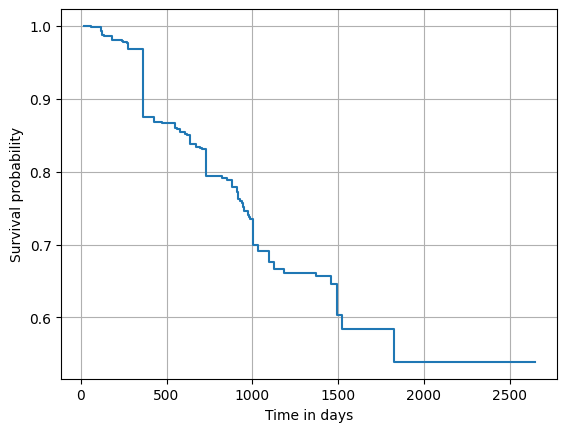

In [ ]:
print(list(categories_set)[0])

surv = rsf.predict_survival_function(company_total_17_22[[list(categories_set)[0] in i for i in company_total_17_22['industry']]].drop(['result', 'Duration', 'Z_score', 'cmpSclNm', 'industry'],axis=1), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
# plt.legend()
plt.grid(True)

생산


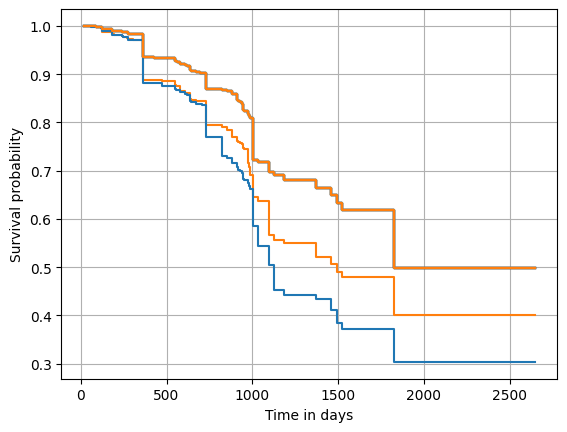

In [ ]:
index = 5

print(list(categories_set)[index])

surv = rsf.predict_survival_function(company_total_17_22[[list(categories_set)[index] in i for i in company_total_17_22['industry']]].drop(['result', 'Duration', 'Z_score', 'cmpSclNm', 'industry'],axis=1), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
# plt.legend()
plt.grid(True)

In [ ]:
# scikit-learn의 기능 중요도(어떤 인자가 영향을 많이 주는 인자인지) 계산 방식에는 문제점이 있지만,
# 다른 방법을 통해 해결 : permutation_importance

from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
재무안정성,0.046735,0.022369
rnd_count,0.043972,0.023903
mark_count,0.026301,0.013784
design_count,0.023059,0.013438
design_score,0.000363,0.000672
design:rnd,0.000226,0.000146
patent_count,0.000060,0.000112
mark_score,0.000044,0.000183
patent_score,0.000000,0.000000
patent:rnd,0.000000,0.000000


In [ ]:
company_final_df = pd.read_excel('../Data/company_keyword.xlsx', engine='openpyxl')

In [ ]:
invest_df = pd.read_excel('../Data/dmc_crwaling.xlsx', engine='openpyxl')

In [ ]:
def split_words(text):
    return [word.strip() for segment in text.split(",") for word in segment.split("/")]

# 컬럼에 함수 적용
invest_df['contents'] = invest_df['contents'].apply(lambda x: split_words(x))

In [ ]:
company_final_df = company_final_df.fillna('')

In [ ]:
company_final_df['total_keyword'] = company_final_df['rnd_keyword'] + company_final_df['design'] + company_final_df['patent'] + company_final_df['mark']

In [ ]:
company_final_df = company_final_df[['BusinessNum', company_final_df.columns[2], 'industry', 'total_keyword']]

In [ ]:
invest_couple = []

for i in invest_df.index:
    for c in invest_df['contents'][i]:
        for f in company_final_df.index:
            keywords = company_final_df['total_keyword'][f]
            if c in keywords:
                invest_couple.append({invest_df['company'][i] : company_final_df['BusinessNum'][f]})